In [129]:
import networkx as nx
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from PIL import Image
import random
import copy
import time

warnings.filterwarnings("ignore")

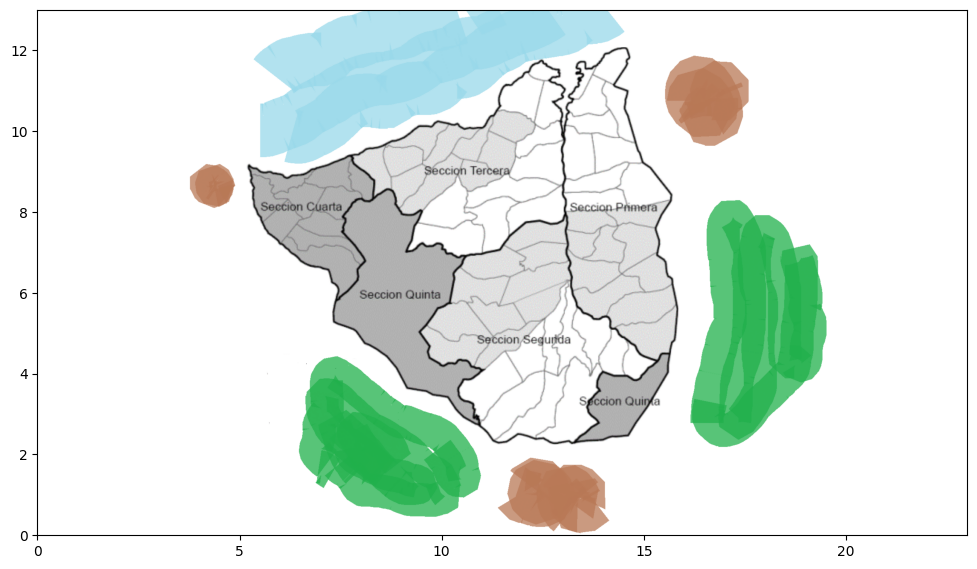

In [130]:
img = Image.open('mapa_iruelas.png')
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(img, extent=[0, 23, 0, 13])
plt.show()

In [131]:
G = nx.DiGraph()

G.add_nodes_from(["CB", "4U", "3B", "3A", "1A", "ET",
                 "51", "2B", "1B", "PY", 
                 "LE", "2A", "52", 
                 "CA"])

direccion_1 = [("CB", "4U"), ("4U", "3B"), ("3B", "3A"), ("3A", "1A"), ("1A", "ET"),
               ("4U", "51"), ("3B", "51"), ("3A", "51"), ("3A", "2B"), ("1A", "1B"),
               ("51", "2B"), ("2B", "1B"), ("1B", "PY"),
               ("51", "LE"), ("51", "2A"), ("1B", "2A"), ("1B", "52"), ("52", "PY"),
               ("LE", "2A"), ("2A", "52"),
               ("2A", "CA"), ("52", "CA")
                ]

direccion_2 = []
for i in direccion_1:
    direccion_2.append((i[1], i[0]))

G.add_edges_from(direccion_1)
G.add_edges_from(direccion_2)

p_apagado =     {"CB":0.9, "4U":0.7, "3B":0.6, "3A":0.6, "1A":0.95, "ET":0.9,
                 "51":0.7, "2B":0.9, "1B":0.7, "PY":0.6, 
                 "LE":0.6, "2A":0.9, "52":0.7, 
                 "CA":0.9}

nx.set_node_attributes(G, p_apagado, 'p_apagado')

p_contagio =  [("CB", "4U",0.0), ("4U", "3B",0.2), ("3B", "3A",0.3), ("3A", "1A",0.1), ("1A", "ET",0.05),
               ("4U", "51",0.2), ("3B", "51",0.3), ("3A", "51",0.3), ("3A", "2B",0.1), ("1A", "1B",0.1),
               ("51", "2B",0.1), ("2B", "1B",0.2), ("1B", "PY",0.3),
               ("51", "LE",0.3), ("51", "2A",0.2), ("1B", "2A",0.2), ("1B", "52",0.3), ("52", "PY",0.3),
               ("LE", "2A",0.2), ("2A", "52",0.1),
               ("2A", "CA",0.05), ("52", "CA",0.1),

               ('4U', 'CB',0.4), ('3B', '4U',0.2), ('3A', '3B',0.3), ('1A', '3A',0.1), ('ET', '1A',0.0),
               ('51', '4U',0.2), ('51', '3B',0.3), ('51', '3A',0.3), ('2B', '3A',0.1), ('1B', '1A',0.1),
               ('2B', '51',0.1), ('1B', '2B',0.2), ('PY', '1B',0.3),
               ('LE', '51',0.3), ('2A', '51',0.2), ('2A', '1B',0.2), ('52', '1B',0.3), ('PY', '52',0.3),
               ('2A', 'LE',0.2), ('52', '2A',0.1),
               ('CA', '2A',0.0), ('CA', '52',0.0)]

G.add_weighted_edges_from(p_contagio)


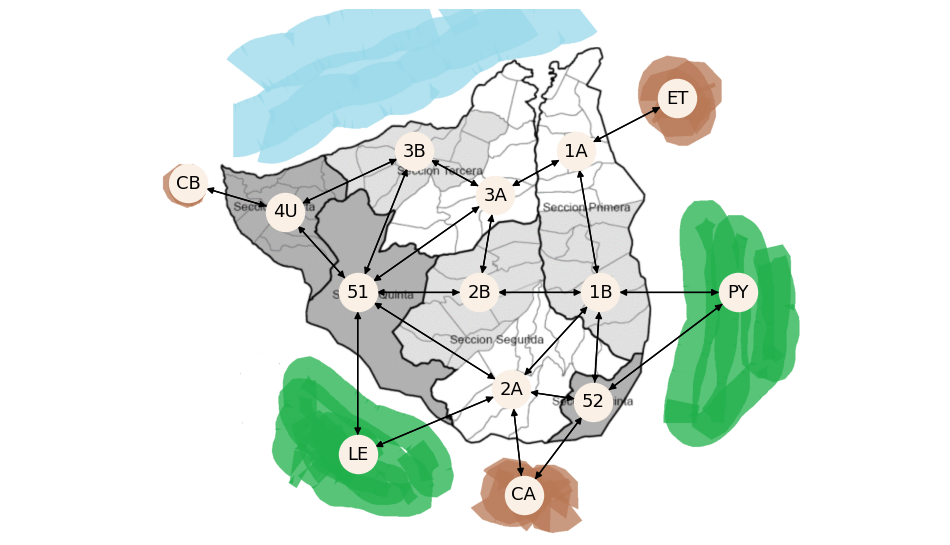

In [132]:
pos = {"CB":(4.4,8.7), "4U":(6.8,8), "3B":(10,9.5), "3A":(12,8.4), "1A":(14,9.5), "ET":(16.5,10.8),
                 "51":(8.6,6), "2B":(11.6,6), "1B":(14.6,6), "PY":(18,6), 
                 "LE":(8.6,2), "2A":(12.4,3.6), "52":(14.43,3.3), 
                 "CA":(12.7,1)}
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(img, extent=[0, 23, 0, 13])
nx.draw(G, pos, ax=ax, with_labels=True, node_color='linen', node_size=750, font_size=13, font_color='black')
plt.show()

In [133]:
def simulacion(p_contagio, obj_seguridad, obj_valor, gif, factor_p_contagio):
    G = nx.DiGraph()
    G.add_nodes_from(["CB", "4U", "3B", "3A", "1A", "ET",
                    "51", "2B", "1B", "PY", 
                    "LE", "2A", "52", 
                    "CA"])
    direccion_1 = [("CB", "4U"), ("4U", "3B"), ("3B", "3A"), ("3A", "1A"), ("1A", "ET"),
                ("4U", "51"), ("3B", "51"), ("3A", "51"), ("3A", "2B"), ("1A", "1B"),
                ("51", "2B"), ("2B", "1B"), ("1B", "PY"),
                ("51", "LE"), ("51", "2A"), ("1B", "2A"), ("1B", "52"), ("52", "PY"),
                ("LE", "2A"), ("2A", "52"),
                ("2A", "CA"), ("52", "CA")
                    ]
    direccion_2 = []
    for i in direccion_1:
        direccion_2.append((i[1], i[0]))
    G.add_edges_from(direccion_1)
    G.add_edges_from(direccion_2)
    quemado = {"CB":0, "4U":0, "3B":0, "3A":0, "1A":0, "ET":0,
                "51":0, "2B":0, "1B":0, "PY":0, 
                "LE":0, "2A":0, "52":0, 
                "CA":0}
    comprobando = {"CB":0, "4U":0, "3B":0, "3A":0, "1A":0, "ET":0,
                "51":0, "2B":0, "1B":0, "PY":0, 
                "LE":0, "2A":0, "52":0, 
                "CA":0}
    nx.set_node_attributes(G, quemado, 'quemado')
    nx.set_node_attributes(G, comprobando, 'comprobando')
    G.add_weighted_edges_from(p_contagio)

    if gif:
        img = Image.open('mapa_iruelas.png')
        pos = {"CB":(4.4,8.7), "4U":(6.8,8), "3B":(10,9.5), "3A":(12,8.4), "1A":(14,9.5), "ET":(16.5,10.8),
            "51":(8.6,6), "2B":(11.6,6), "1B":(14.6,6), "PY":(18,6), 
            "LE":(8.6,2), "2A":(12.4,3.6), "52":(14.43,3.3), 
            "CA":(12.7,1)}
        fig, ax = plt.subplots(figsize = (12,12))
        ax.imshow(img, extent=[0, 23, 0, 13])
        colores_nodos = []
        for i in G.nodes:
            if G.nodes[i]["comprobando"] == 1:
                colores_nodos.append("red")
            elif G.nodes[i]["quemado"] == 1:
                colores_nodos.append("red")
            else:
                colores_nodos.append("linen")
        # print(len(colores_nodos))
        nx.draw(G, pos, ax=ax, with_labels=True, node_color=colores_nodos, node_size=750, font_size=13, font_color='black')

    # quemar un nodo
    nodo_inicial = random.choice(["4U", "3B", "3A", "1A",
                    "51", "2B", "1B", "PY", 
                    "LE", "2A", "52"])
    G.nodes[nodo_inicial]["quemado"] = 1
    G.nodes[nodo_inicial]["comprobando"] = 1

    if gif:
        img = Image.open('mapa_iruelas.png')
        pos = {"CB":(4.4,8.7), "4U":(6.8,8), "3B":(10,9.5), "3A":(12,8.4), "1A":(14,9.5), "ET":(16.5,10.8),
            "51":(8.6,6), "2B":(11.6,6), "1B":(14.6,6), "PY":(18,6), 
            "LE":(8.6,2), "2A":(12.4,3.6), "52":(14.43,3.3), 
            "CA":(12.7,1)}
        fig, ax = plt.subplots(figsize = (12,12))
        ax.imshow(img, extent=[0, 23, 0, 13])
        colores_nodos = []
        for i in G.nodes:
            if G.nodes[i]["comprobando"] == 1:
                colores_nodos.append("red")
            elif G.nodes[i]["quemado"] == 1:
                colores_nodos.append("red")
            else:
                colores_nodos.append("linen")
        # print(len(colores_nodos))
        nx.draw(G, pos, ax=ax, with_labels=True, node_color=colores_nodos, node_size=750, font_size=13, font_color='black')

    alguno_sin_comprobar = True

    while alguno_sin_comprobar:
        alguno_sin_comprobar = False
        copia_nodos = copy.deepcopy(nx.get_node_attributes(G, 'quemado'))
        copia_grafo = copy.deepcopy(G)
        for nodo in copia_grafo.nodes:
            if G.nodes[nodo]["comprobando"] == 1:
                alguno_sin_comprobar = True
                for vecino in G.neighbors(nodo):
                    cortafuegos = random.random()
                    if cortafuegos < G[nodo][vecino]["weight"]*factor_p_contagio:
                        if copia_grafo.nodes[vecino]["quemado"] == 0:
                            copia_grafo.nodes[vecino]["quemado"] = 1
                            copia_grafo.nodes[vecino]["comprobando"] = 1
                copia_grafo.nodes[nodo]["comprobando"] = 0
        G = copia_grafo
        
        if gif and copia_nodos != nx.get_node_attributes(G, 'quemado'):
        # if True:
            fig, ax = plt.subplots(figsize = (12,12))
            ax.imshow(img, extent=[0, 23, 0, 13])
            quemado_nodos = nx.get_node_attributes(G, 'quemado')
            colores_nodos = [
                'red' if quemado_nodos[nodo] == 1 else "linen"
                for nodo in G.nodes]
            nx.draw(G, pos, ax=ax, with_labels=True, node_color=colores_nodos, node_size=750, font_size=13, font_color='black')
    total_seguridad = sum(obj_seguridad.values())
    total_entorno   = sum(obj_valor.values())
    seguridad_afectada, entorno_afectado = 0, 0
    for j in G.nodes:
        # print(quemado[j], obj_seguridad[j], quemado, obj_seguridad)
        seguridad_afectada += nx.get_node_attributes(G, 'quemado')[j] * obj_seguridad[j]
        entorno_afectado   += nx.get_node_attributes(G, 'quemado')[j] * obj_valor[j]
    result = {"seguridad_afectada":round(seguridad_afectada/total_seguridad, 2), "entorno_afectado":round(entorno_afectado/total_entorno, 2)}
    return result

    

In [134]:
p_contagio_1 =  [("CB", "4U",0.0), ("4U", "3B",0.2), ("3B", "3A",0.3), ("3A", "1A",0.1), ("1A", "ET",0.05),
            ("4U", "51",0.2), ("3B", "51",0.3), ("3A", "51",0.3), ("3A", "2B",0.1), ("1A", "1B",0.1),
            ("51", "2B",0.1), ("2B", "1B",0.2), ("1B", "PY",0.3),
            ("51", "LE",0.3), ("51", "2A",0.2), ("1B", "2A",0.2), ("1B", "52",0.3), ("52", "PY",0.3),
            ("LE", "2A",0.2), ("2A", "52",0.1),
            ("2A", "CA",0.05), ("52", "CA",0.1),
            ('4U', 'CB',0.4), ('3B', '4U',0.2), ('3A', '3B',0.3), ('1A', '3A',0.1), ('ET', '1A',0.0),
            ('51', '4U',0.2), ('51', '3B',0.3), ('51', '3A',0.3), ('2B', '3A',0.1), ('1B', '1A',0.1),
            ('2B', '51',0.1), ('1B', '2B',0.2), ('PY', '1B',0.3),
            ('LE', '51',0.3), ('2A', '51',0.2), ('2A', '1B',0.2), ('52', '1B',0.3), ('PY', '52',0.3),
            ('2A', 'LE',0.2), ('52', '2A',0.1),
            ('CA', '2A',0.0), ('CA', '52',0.0)]
obj_seguridad_1 = {"CB":1, "4U":0, "3B":0, "3A":0.2, "1A":0.2, "ET":1,
                "51":0, "2B":0.2, "1B":0.2, "PY":0, 
                "LE":0, "2A":0.2, "52":0.2, 
                "CA":1}
obj_valor_1 = {"CB":0, "4U":0.5, "3B":0.85, "3A":0.85, "1A":0.5, "ET":0,
                "51":0.3, "2B":0.5, "1B":0.5, "PY":0.2, 
                "LE":0.2, "2A":0.5, "52":0.3, "CA":0}
gif_1 = True
factor_p_contagio_1 = 1

In [135]:
# simulacion(p_contagio_1, obj_seguridad_1, obj_valor_1, gif_1, factor_p_contagio_1)
simulacion(p_contagio_1, obj_seguridad_1, obj_valor_1, False, factor_p_contagio_1)

{'seguridad_afectada': 0.14, 'entorno_afectado': 0.29}

In [142]:
def simulacionES(obj_seguridad, obj_valor, p_contagio, factor_p_contagio, num_iter):
    t_0 = time.time()
    total_seguridad, total_entorno = 0, 0
    for iter in range(num_iter):
        # print(iter, simulacion(p_contagio, obj_seguridad, obj_valor, False, factor_p_contagio))
        total_seguridad += simulacion(p_contagio, obj_seguridad, obj_valor, False, factor_p_contagio)["seguridad_afectada"]
        total_entorno   += simulacion(p_contagio, obj_seguridad, obj_valor, False, factor_p_contagio)["entorno_afectado"]
    t_final = time.time() - t_0
    return {"seguridad_afectada":round(total_seguridad/num_iter, 2), "entorno_afectado":round(total_entorno/num_iter, 2), "tiempo [s]": int(t_final)}


In [149]:
print(simulacionES(obj_seguridad_1, obj_valor_1, p_contagio_1, 0.5, 10**4),
      simulacionES(obj_seguridad_1, obj_valor_1, p_contagio_1, 0.75, 10**4),
      simulacionES(obj_seguridad_1, obj_valor_1, p_contagio_1, 1, 10**4),
      simulacionES(obj_seguridad_1, obj_valor_1, p_contagio_1, 1.25, 10**4),
      simulacionES(obj_seguridad_1, obj_valor_1, p_contagio_1, 1.5, 10**4),
      simulacionES(obj_seguridad_1, obj_valor_1, p_contagio_1, 1.75, 10**4),
      simulacionES(obj_seguridad_1, obj_valor_1, p_contagio_1, 2, 10**4)
)

KeyboardInterrupt: 

In [ ]:
# {'seguridad_afectada': 0.05, 'entorno_afectado': 0.13, 'tiempo [s]': 17}
# {'seguridad_afectada': 0.06, 'entorno_afectado': 0.16, 'tiempo [s]': 16}
# {'seguridad_afectada': 0.08, 'entorno_afectado': 0.21, 'tiempo [s]': 17}
# {'seguridad_afectada': 0.11, 'entorno_afectado': 0.25, 'tiempo [s]': 24}
# {'seguridad_afectada': 0.14, 'entorno_afectado': 0.31, 'tiempo [s]': 26} 
# {'seguridad_afectada': 0.18, 'entorno_afectado': 0.38, 'tiempo [s]': 27} 
# {'seguridad_afectada': 0.24, 'entorno_afectado': 0.45, 'tiempo [s]': 38}